## HW2

> using SGD & 200epoch test dynamic LR

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# see more data augmentation https://pytorch.org/vision/stable/transforms.html
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)]) # calculte yourself

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)]) # calculte yourself

batch_size = 64
num_classes = 100    # check

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# pick one

# 1. model defined by yourself
# model = Toy_CNN()        
   
# 2. off-the-shelf model
# see https://pytorch.org/vision/stable/models.html
# nn.Linear https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
model = models.resnet50(pretrained=True) 
model.fc = torch.nn.Linear(2048, num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.0001,
#                        weight_decay=1e-4)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# dynamic learning rate
train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120,160], gamma=0.1)
total_epoch = 200
print_per_iteration = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/ML_HW2/Optimal_Function/SGD_200epoch_dynamicLR_model.pth'

lrs = []

for epoch in range(total_epoch):  # loop over the dataset multiple times
    check_lr = get_lr(optimizer)
    lrs.append(check_lr)
    print(f'[ep {epoch + 1}] lr : {check_lr:.5f}')
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # get learning rate

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_scheduler.step()
        # print statistics
        # if (i+1) % print_per_iteration == 0:    # print every 2000 mini-batches
        #     print(f'[ep {epoch + 1}][{i + 1:5d}/{len(trainloader):5d}] loss: {loss.item():.3f}')
    torch.save(model, save_path)

# fixed testing process
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of SGD : {100 * correct / total:.2f} %')

[ep 1] lr : 0.10000
[ep 2] lr : 0.10000
[ep 3] lr : 0.10000
[ep 4] lr : 0.10000
[ep 5] lr : 0.10000
[ep 6] lr : 0.10000
[ep 7] lr : 0.10000
[ep 8] lr : 0.10000
[ep 9] lr : 0.10000
[ep 10] lr : 0.10000
[ep 11] lr : 0.10000
[ep 12] lr : 0.10000
[ep 13] lr : 0.10000
[ep 14] lr : 0.10000
[ep 15] lr : 0.10000
[ep 16] lr : 0.10000
[ep 17] lr : 0.10000
[ep 18] lr : 0.10000
[ep 19] lr : 0.10000
[ep 20] lr : 0.10000
[ep 21] lr : 0.10000
[ep 22] lr : 0.10000
[ep 23] lr : 0.10000
[ep 24] lr : 0.10000
[ep 25] lr : 0.10000
[ep 26] lr : 0.10000
[ep 27] lr : 0.10000
[ep 28] lr : 0.10000
[ep 29] lr : 0.10000
[ep 30] lr : 0.10000
[ep 31] lr : 0.10000
[ep 32] lr : 0.10000
[ep 33] lr : 0.10000
[ep 34] lr : 0.10000
[ep 35] lr : 0.10000
[ep 36] lr : 0.10000
[ep 37] lr : 0.10000
[ep 38] lr : 0.10000
[ep 39] lr : 0.10000
[ep 40] lr : 0.10000
[ep 41] lr : 0.10000
[ep 42] lr : 0.10000
[ep 43] lr : 0.10000
[ep 44] lr : 0.10000
[ep 45] lr : 0.10000
[ep 46] lr : 0.10000
[ep 47] lr : 0.10000
[ep 48] lr : 0.10000
[

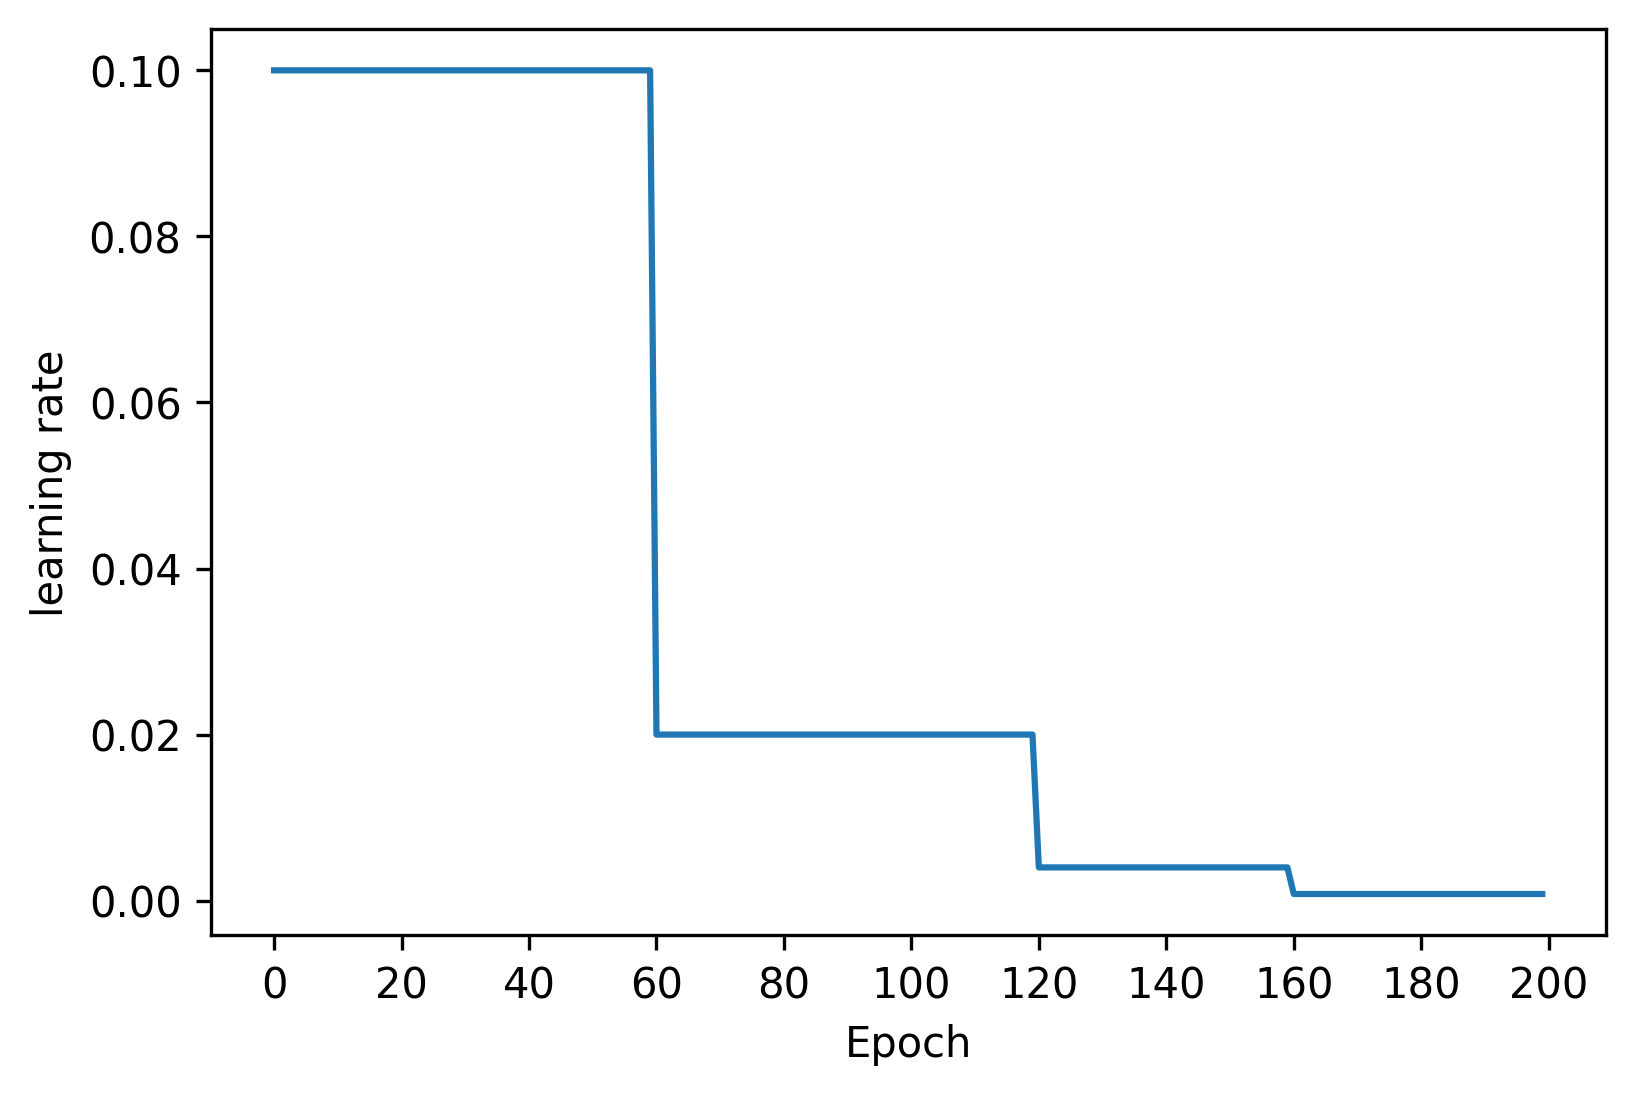

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['figure.dpi'] = 300
plt.plot(lrs)
plt.xticks(np.arange(0,220,step=20))
plt.xlabel('Epoch')
plt.ylabel('learning rate')
plt.show()

In [ ]:
# load trained model
# model = torch.load("./model.pth")
# model.to(device)

# fixed testing process
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 60.61 %


Accuracy of the network on the 10000 test images: 60.19 %